In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import math
import json
# import shap
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from xgboost import XGBRegressor, plot_importance
from mpl_toolkits.mplot3d import Axes3D

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Pre-processing and Feature Engineering

### `portfolio` dataset

In [3]:
portfolio_channels = pd.get_dummies(pd.DataFrame(portfolio['channels'].values.tolist()).stack()).sum(level=0)
portfolio = pd.concat([portfolio.drop(['channels'], axis=1), portfolio_channels], axis=1 )
portfolio['offer_combo'] = (
    portfolio
    .filter(['offer_type', 'reward', 'difficulty', 'duration'])
    .astype(str)
    .agg('_'.join, axis=1)
)
portfolio 

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,offer_combo
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_10_10_7
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_0_0_4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_5_5_7
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount_5_20_10
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_7_7
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_10_10
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,informational_0_0_3
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,discount_2_10_7


### `profile` dataset

In [4]:
profile = (
    profile
    .assign(member_year=profile['became_member_on'].astype(str).str[:4].astype(int),
           member_month=profile['became_member_on'].astype(str).str[4:6].astype(int),
           member_date=profile['became_member_on'].astype(str).str[6:8].astype(int))
    .drop(['became_member_on'], axis=1)
)
profile.head()

,gender,age,id,income,member_year,member_month,member_date
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4


In [5]:
profile[profile['gender'].isnull()].head()

,gender,age,id,income,member_year,member_month,member_date
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,NaN,2017,10,2


### `transcript` dataset

In [6]:
def process_transcript(event_type):
    val_text = 'offer ' + event_type
    time_col = 'offer_' + event_type + '_time'
    key = 'offer_id' if event_type == 'completed' else 'offer id'
    data = (
        transcript
        .query('event == @val_text')
        .assign(offer_id=lambda x: [d.get(key) for d in x['value']])
        .rename(columns={'time': time_col})
        .filter(['person', 'offer_id', time_col])
    )
    return data

def create_offer_count_features(data, event_type):
    old_col_name = 'offer_' + event_type + '_time'
    new_col_name = event_type + '_count'
    prefix = event_type + '_count_'
    grouped_data = (
        data
        .groupby(['person', 'offer_id'])
        .agg('count')
        .reset_index()
        .rename(columns={old_col_name: new_col_name})
        .merge(portfolio[['id', 'offer_combo']], how='left', left_on='offer_id', right_on='id')
        .filter(['person', 'offer_combo', new_col_name])
        .pivot(index='person', columns='offer_combo', values=new_col_name)
        .fillna(0)
        .assign(bogo_total=lambda x: x.filter(regex='bogo').sum(axis=1), 
               discount_total=lambda x: x.filter(regex='discount').sum(axis=1),
               informational_total=lambda x: x.filter(regex='informational').sum(axis=1),
               total=lambda x: x.filter(regex='total').sum(axis=1))
        .add_prefix(prefix)
        .reset_index()
    )
    
    return grouped_data

In [7]:
# those who received the offers 
offer_received = process_transcript('received')
received_ct_ids = create_offer_count_features(offer_received, 'received')
received_ct_ids.head()

offer_combo,person,received_count_bogo_10_10_5,received_count_bogo_10_10_7,received_count_bogo_5_5_5,received_count_bogo_5_5_7,received_count_discount_2_10_10,received_count_discount_2_10_7,received_count_discount_3_7_7,received_count_discount_5_20_10,received_count_informational_0_0_3,received_count_informational_0_0_4,received_count_bogo_total,received_count_discount_total,received_count_informational_total,received_count_total
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,5.0
1,00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
2,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0
3,0020c2b971eb4e9188eac86d93036a77,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,5.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,4.0


In [8]:
# those who viewed the offers
offer_viewed = process_transcript('viewed')
viewed_ct_ids = create_offer_count_features(offer_viewed, 'viewed')
viewed_ct_ids.head()

offer_combo,person,viewed_count_bogo_10_10_5,viewed_count_bogo_10_10_7,viewed_count_bogo_5_5_5,viewed_count_bogo_5_5_7,viewed_count_discount_2_10_10,viewed_count_discount_2_10_7,viewed_count_discount_3_7_7,viewed_count_discount_5_20_10,viewed_count_informational_0_0_3,viewed_count_informational_0_0_4,viewed_count_bogo_total,viewed_count_discount_total,viewed_count_informational_total,viewed_count_total
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,4.0
1,00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
2,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0
3,0020c2b971eb4e9188eac86d93036a77,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,4.0


In [9]:
# those who completed the offers; note that this might include who didn't view, 
# thus didn't get affected by the offer
offer_completed = process_transcript('completed')
completed_ct_ids = create_offer_count_features(offer_completed, 'completed')
completed_ct_ids.head()

offer_combo,person,completed_count_bogo_10_10_5,completed_count_bogo_10_10_7,completed_count_bogo_5_5_5,completed_count_bogo_5_5_7,completed_count_discount_2_10_10,completed_count_discount_2_10_7,completed_count_discount_3_7_7,completed_count_discount_5_20_10,completed_count_bogo_total,completed_count_discount_total,completed_count_informational_total,completed_count_total
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,3.0
1,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,3.0
2,0020c2b971eb4e9188eac86d93036a77,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0
3,0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,3.0
4,003d66b6608740288d6cc97a6903f4f0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0


In [10]:
# those who made at least a transactions; note that this include both those 
# influenced and not influenced by promotional offers
transactions = (
    transcript
    .query('event == "transaction"')
    .assign(amount=lambda x: [d.get('amount') for d in x['value']])
    .rename(columns={'time': 'transaction_time'})
    .filter(['person', 'amount', 'transaction_time'])
    .sort_values(by=['person', 'transaction_time'])
    .assign(between_time=lambda x: x.groupby('person')['transaction_time'].transform(lambda x: x.diff()))
)

grouped_transactions = (
    transactions
    .groupby('person')
    .agg({'amount': ['count', 'sum', 'mean'], 'between_time': 'mean'})
    .reset_index()
    .droplevel(1, axis=1) 
)
grouped_transactions.columns = ['person', 'num_transactions', 'total_spent', 'mean_spent', 'mean_between_time']
grouped_transactions.head()

,person,num_transactions,total_spent,mean_spent,mean_between_time
0,0009655768c64bdeb2e877511632db8f,8,127.60,15.950000,66.857143
1,00116118485d4dfda04fdbaba9a87b5c,3,4.09,1.363333,90.000000
2,0011e0d4e6b944f998e987f904e8c1e5,5,79.46,15.892000,130.500000
3,0020c2b971eb4e9188eac86d93036a77,8,196.86,24.607500,93.428571
4,0020ccbbb6d84e358d3414a3ff76cffd,12,154.05,12.837500,57.272727


In [11]:
# those who completed the offers after viewing them and were eligible for rewards
completed_viewers = (
    offer_viewed
    .merge(offer_completed, how='left', on=['person', 'offer_id'])
    .query('offer_completed_time.notnull()', engine='python')
    .assign(completed_duration=lambda x: (x['offer_completed_time']-x['offer_viewed_time']) / 24)
    .merge(portfolio[['duration', 'id']], how='left', left_on='offer_id', right_on='id')
    .query('0 <= completed_duration <= duration')
    .merge(transactions[['person', 'transaction_time']], how='left', left_on=['person', 'offer_completed_time'], 
           right_on=['person', 'transaction_time'])
    .merge(portfolio[['id', 'offer_combo']], how='left', left_on='offer_id', right_on='id')
    .assign(mean_completed_by_offer=lambda x: x.groupby(['person', 'offer_id'])['completed_duration'].transform('mean'), 
            mean_completed_total=lambda x: x.groupby(['person'])['completed_duration'].transform('mean'))
    .filter(['person', 'offer_combo', 'mean_completed_by_offer', 'mean_completed_total'])
    .pivot_table(index=['person', 'mean_completed_total'], columns='offer_combo', 
                 values='mean_completed_by_offer', fill_value=0)
    .add_prefix('mean_completed_')
    .reset_index()
)
completed_viewers.head()

offer_combo,person,mean_completed_total,mean_completed_bogo_10_10_5,mean_completed_bogo_10_10_7,mean_completed_bogo_5_5_5,mean_completed_bogo_5_5_7,mean_completed_discount_2_10_10,mean_completed_discount_2_10_7,mean_completed_discount_3_7_7,mean_completed_discount_5_20_10
0,0011e0d4e6b944f998e987f904e8c1e5,3.750000,0.0,0.0,0.00,2.50,0.000000,0.0,2.75,6.0
1,0020c2b971eb4e9188eac86d93036a77,2.625000,3.5,0.0,0.00,0.00,1.750000,0.0,0.00,0.0
2,0020ccbbb6d84e358d3414a3ff76cffd,1.416667,0.0,0.0,1.25,0.75,0.000000,0.0,2.25,0.0
3,003d66b6608740288d6cc97a6903f4f0,5.166667,0.0,0.0,0.00,0.00,5.166667,0.0,0.00,0.0
4,00426fe3ffde4c6b9cb9ad6d077a13ea,3.000000,0.0,0.0,0.00,0.00,3.000000,0.0,0.00,0.0


### Final dataset for modeling

In [12]:
len(set(received_ct_ids['person']).intersection(set(profile['id']))) == received_ct_ids['person'].nunique()

True

In [13]:
len(set(viewed_ct_ids['person']).intersection(set(profile['id']))) == viewed_ct_ids['person'].nunique()

True

In [14]:
len(set(completed_ct_ids['person']).intersection(set(profile['id']))) == completed_ct_ids['person'].nunique()

True

In [15]:
len(set(grouped_transactions['person']).intersection(set(profile['id']))) == grouped_transactions['person'].nunique()

True

In [16]:
len(set(completed_viewers['person']).intersection(set(profile['id']))) == completed_viewers['person'].nunique()

True

In [17]:
all_profiles = (
    profile
    .merge(received_ct_ids, how='left', left_on='id', right_on='person')
    .merge(viewed_ct_ids, how='left', left_on='id', right_on='person')
    .merge(completed_ct_ids, how='left', left_on='id', right_on='person')
    .merge(grouped_transactions, how='left', left_on='id', right_on='person')
    .merge(completed_viewers, how='left', left_on='id', right_on='person')
)
all_profiles.drop(list(all_profiles.filter(regex='person')), axis=1, inplace=True)
cols_to_impute = [c for c in all_profiles.columns if c not in ['gender', 'income']]
all_profiles.update(all_profiles[cols_to_impute].fillna(0))
all_profiles.head()

,gender,age,id,income,member_year,member_month,member_date,received_count_bogo_10_10_5,received_count_bogo_10_10_7,received_count_bogo_5_5_5,...,mean_between_time,mean_completed_total,mean_completed_bogo_10_10_5,mean_completed_bogo_10_10_7,mean_completed_bogo_5_5_5,mean_completed_bogo_5_5_7,mean_completed_discount_2_10_10,mean_completed_discount_2_10_7,mean_completed_discount_3_7_7,mean_completed_discount_5_20_10
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,0.0,0.0,0.0,...,42.0,4.00,0.0,0.00,0.0,0.00,6.0,0.0,2.0,0.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,0.0,0.0,0.0,...,255.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,0.0,0.0,0.0,...,112.8,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,0.0,1.0,1.0,...,67.0,4.75,0.0,4.25,0.0,5.25,0.0,0.0,0.0,0.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4,0.0,0.0,0.0,...,189.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0


## Feature Analysis

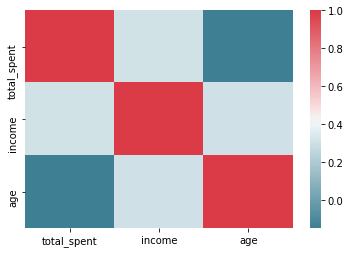

In [18]:
corr = all_profiles[['total_spent', 'income', 'age']].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [ ]:
sns.pairplot(all_profiles.drop(['gender', 'id', 'member_year', 'member_month', 'member_date'], axis=1))

## Feature Transformation

PCA and scaling/normalization

## K-means clustering

## Model analysis